Dataset : Madrid weather dataset hourly 2019-2022

link dataset : https://www.kaggle.com/datasets/rober2598/madrid-weather-dataset-by-hours-20192022

In [1]:
#import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#mengekstrak file dari google drive
!unzip "/content/drive/MyDrive/machine learning/archive.zip" -d "/content/drive/MyDrive/machine learning/madridWeather"

Archive:  /content/drive/MyDrive/machine learning/archive.zip
replace /content/drive/MyDrive/machine learning/madridWeather/weather_madrid_2019-2022.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/machine learning/madridWeather/weather_madrid_2019-2022.csv  


In [4]:
#mengubah dataset menjadi dataframe
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/machine learning/madridWeather/weather_madrid_2019-2022.csv")
df.head()

,Unnamed: 0,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,0,2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
1,1,2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2,2,2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
3,3,2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
4,4,2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0


In [5]:
#cek nilai null
df.isnull().sum()

Unnamed: 0             0
time                   0
temperature            0
wind_speed             0
wind_direction         0
humidity               0
barometric_pressure    0
solar_radiation        0
precipitation          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27024 entries, 0 to 27023
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27024 non-null  int64  
 1   time                 27024 non-null  object 
 2   temperature          27024 non-null  float64
 3   wind_speed           27024 non-null  float64
 4   wind_direction       27024 non-null  float64
 5   humidity             27024 non-null  float64
 6   barometric_pressure  27024 non-null  float64
 7   solar_radiation      27024 non-null  float64
 8   precipitation        27024 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.9+ MB


In [9]:
#mengubah formate time ke date 
df['time']=pd.to_datetime(df['time'])
df['time'].head()

#mengambil kolom time & temperature
df = df[['time','temperature' ]]
df.head()

,time,temperature
0,2019-01-01 00:59:59,3.1
1,2019-01-01 01:59:59,2.9
2,2019-01-01 02:59:59,3.1
3,2019-01-01 03:59:59,1.9
4,2019-01-01 04:59:59,0.7


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27024 entries, 0 to 27023
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         27024 non-null  datetime64[ns]
 1   temperature  27024 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 422.4 KB


In [11]:
#menghapus waktu yang ada di kolom time,ubah judul jadi date
madrid=df[['time','temperature']].copy()
madrid['date'] = madrid['time'].dt.date

madridfinal=madrid.drop('time',axis=1)
madridfinal.set_index('date', inplace= True)
madridfinal.head()

,temperature
date,
2019-01-01,3.1
2019-01-01,2.9
2019-01-01,3.1
2019-01-01,1.9
2019-01-01,0.7


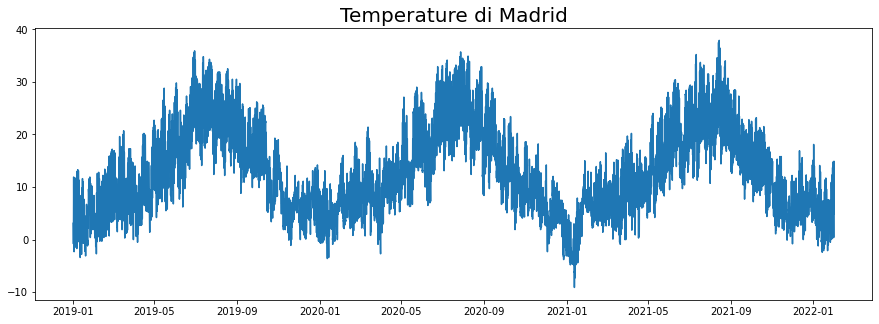

In [12]:
#membuat plot
dates = df['time'].values
temp  = df['temperature'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature di Madrid',
          fontsize=20);

In [14]:
#mengubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
#split dataset untuk data train sebesar 80% & validation set sebesar 20%
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, shuffle = False )

print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_test))

Total Data Train :  21619
Total Data Validation :  5405


In [16]:
#model dengan sequential
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [18]:
#menghitung nilai 10% MAE
threshold_mae = (temp.max() - temp.min()) * 10/100
threshold_mae

4.7

In [19]:
#membuat callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      self.model.stop_training = True
      print("\nMAE sudah kurang dari 10%")
callbacks = myCallback()

In [20]:
#melatih model
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


216/216 [==============================] - 15s 27ms/step - loss: 9.7912 - mae: 10.2798 - val_loss: 7.9170 - val_mae: 8.3992
Epoch 2/100
216/216 [==============================] - 5s 24ms/step - loss: 5.0100 - mae: 5.4878 - val_loss: 4.6981 - val_mae: 5.1777
Epoch 3/100
212/216 [============================>.] - ETA: 0s - loss: 2.8993 - mae: 3.3650
MAE sudah kurang dari 10%
216/216 [==============================] - 6s 27ms/step - loss: 2.8949 - mae: 3.3606 - val_loss: 2.5739 - val_mae: 3.0324


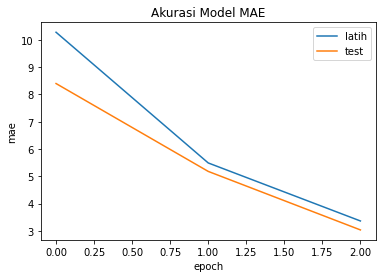

In [22]:
# Plot Akurasi Model MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['latih', 'test'], loc='upper right')
plt.show()

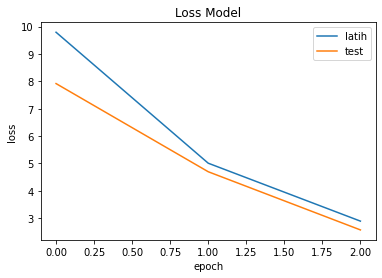

In [23]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['latih', 'test'], loc='upper right')
plt.show()